In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

<Figure size 432x288 with 0 Axes>

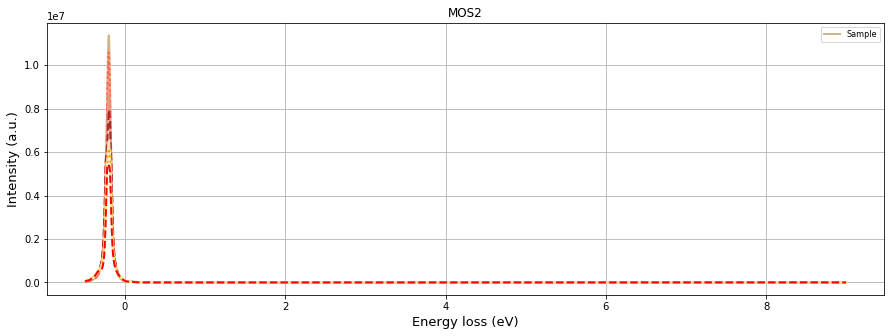

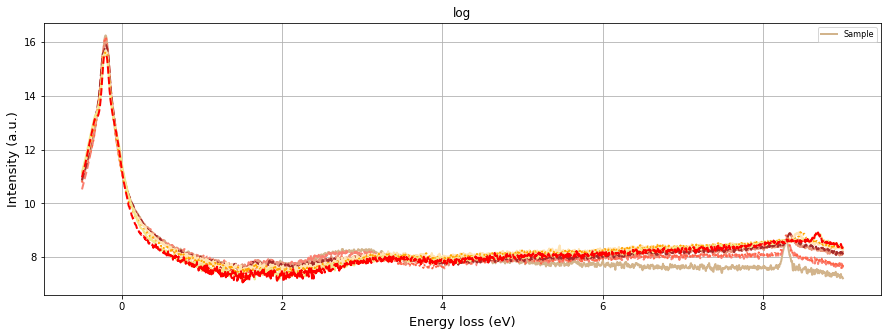

In [2]:
%run EELS-ZLP-May.py

With 200 bins, the minimum number of training points within each bin is 9 and maximum is 10


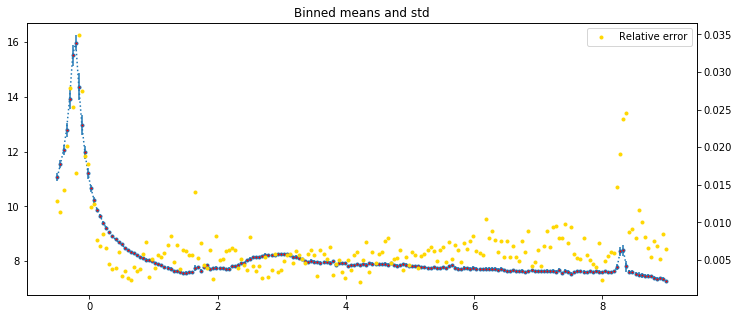

In [3]:
%run Functions.ipynb
fig = plt.gcf()

x_train = x1
y_train = log_y1

nbins = 200
minval = min(x_train)
maxval = max(x_train)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
# create one vector with (x_train, y_train, sigma_train)
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_t)), "and maximum is", int(max(count_t)))

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), np.divide(std_t, mean_t), '.', color='gold',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
fig.set_size_inches(12, 5)
plt.show()



In [4]:
df = pd.DataFrame()

df['x'] = x_train + 0.2025 # shift to align peak with zero loss
df['y'] = y1
df['log_y'] = y_train
df['sigma'] = variance_vector_t
df.head()



,x,y,log_y,sigma
0,-0.295,51009.4,10.839765,0.143041
1,-0.290,53958.4,10.895969,0.143041
2,-0.285,57218.7,10.954636,0.143041
3,-0.280,60768.2,11.014822,0.143041
4,-0.275,64236.4,11.070325,0.143041


### FWHM is 0.03 eV loss. Drop data for $x > 3 * $FWHM



In [5]:
FWHM = max(df[df['y'] > .5 * max(df['y'])]['x'])
df_window = df[df['x'] <= 3 * FWHM]

In [6]:
df_window

,x,y,log_y,sigma
0,-0.295,51009.4,10.839765,0.143041
1,-0.290,53958.4,10.895969,0.143041
2,-0.285,57218.7,10.954636,0.143041
3,-0.280,60768.2,11.014822,0.143041
4,-0.275,64236.4,11.070325,0.143041
...,...,...,...,...
73,0.070,1176000.0,13.977629,0.501472
74,0.075,1012500.0,13.827933,0.501472
75,0.080,878093.0,13.685508,0.501472
76,0.085,764624.0,13.547139,0.357010


### Create pseudo data for $x > a*$ FWHM 

In [7]:
min_x = 30 * FWHM
max_x = 35 * FWHM
N_pseudo = 30


df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': 100 * np.ones(N_pseudo), \
                    'log_y': np.log(2 * np.ones(N_pseudo)), 'sigma': .28 * np.ones(N_pseudo)})



In [8]:
#df_full = df_window

df_full = pd.concat([df_window, df_pseudo])

### Create architecture

In [9]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [10]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full.drop_duplicates(subset=None, inplace=True)
#df_train_pseudo = pd.read_csv('Data/May/pseudo_trainingsdata_x.csv', header=0, names=['x', 'time', 'energy', 'y', 'sigma'])
#df_train_full = pd.concat([df_train_full_1, df_train_pseudo], axis=0, ignore_index=True)

df_train, df_test = train_test_split(df_train_full, test_size=0.2, random_state=27)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = np.copy(df_train['log_y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = np.copy(df_test['log_y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)

predictions = make_model(x,1)


#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
    

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


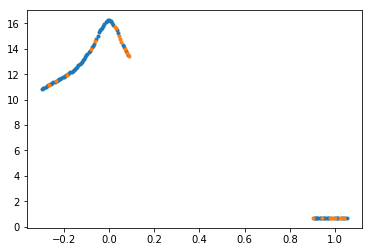

In [11]:
plt.plot(train_x, train_y, '.')
plt.plot(test_x, test_y, '.')

## Create MC replicas

In [12]:
### Create array of Nrep training samples

Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)
    


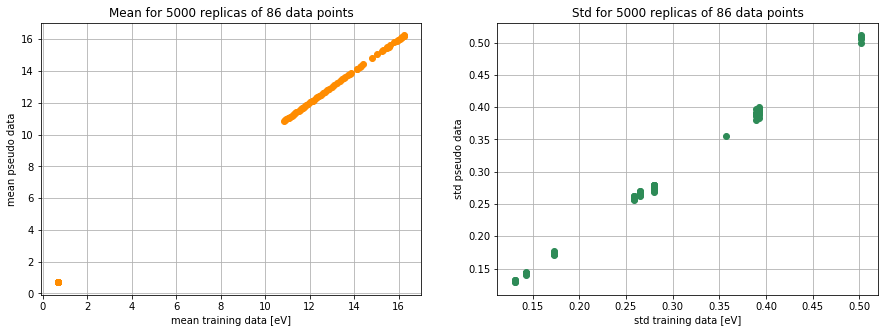

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
#plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
#plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [14]:
N_pred = 6000
predict_x = np.linspace(-.3,3,N_pred).reshape(N_pred,1)

In [15]:
import time
from datetime import datetime


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 5e-4
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 2

    for i in range(Nrep):

        train_y = train_y_reps[:, i*10 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i*10 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 40000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            

            saver.restore(sess, best_model)

            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        now = datetime.now()

        dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
        d_string = now.strftime("%d.%m.%Y")
        t_string = now.strftime("%H:%M:%S")

        #foot = np.array(seednumber)
        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/%(date)s/x2_xyp1p2_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_chi_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_extrapolation_e%(epoch)s_round4_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(k, l)),  delimiter=',', fmt='%f')
 

In [16]:
#function_train(3)

## Parallel training

In [17]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=10
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4,5,6,7,8,9,10])

pool.close()

#print(pool)


processor1 starts training on 0086 and validating on 0022 samples
processor2 starts training on 0086 and validating on 0022 samples
processor4 starts training on 0086 and validating on 0022 samples
processor3 starts training on 0086 and validating on 0022 samples
processor6 starts training on 0086 and validating on 0022 samples
processor7 starts training on 0086 and validating on 0022 samples
processor8 starts training on 0086 and validating on 0022 samples
processor5 starts training on 0086 and validating on 0022 samples
processor10 starts training on 0086 and validating on 0022 samples
processor9 starts training on 0086 and validating on 0022 samples
Epoch: 0001 | Training cost= 2683.945068359 | Validation cost= 1465.275878906
Epoch: 0001 | Training cost= 2662.726074219 | Validation cost= 1446.863281250
Epoch: 0001 | Training cost= 2685.421875000 | Validation cost= 1453.160156250
Epoch: 0001 | Training cost= 2681.678710938 | Validation cost= 1466.414672852
Epoch: 0001 | Training cost

Epoch: 10001 | Training cost= 3.878302336 | Validation cost= 3.754016161
Epoch: 10001 | Training cost= 4.701478004 | Validation cost= 4.029257774
Epoch: 10001 | Training cost= 3.790751696 | Validation cost= 2.948591709
Epoch: 10001 | Training cost= 2.896992207 | Validation cost= 3.745005608
Epoch: 10001 | Training cost= 3.891772270 | Validation cost= 3.245689392
Epoch: 10001 | Training cost= 4.578291416 | Validation cost= 2.499825478
Epoch: 10001 | Training cost= 4.215159416 | Validation cost= 3.905999899
Epoch: 10001 | Training cost= 2.137799978 | Validation cost= 4.080460072
Epoch: 10001 | Training cost= 3.283483028 | Validation cost= 3.953026056
Epoch: 10001 | Training cost= 4.173470497 | Validation cost= 3.813774824
Epoch: 11001 | Training cost= 2.607651472 | Validation cost= 2.029597759
Epoch: 11001 | Training cost= 2.885567665 | Validation cost= 2.259880543
Epoch: 11001 | Training cost= 2.472098589 | Validation cost= 1.495841861
Epoch: 11001 | Training cost= 1.265107989 | Validat

Epoch: 21001 | Training cost= 0.997622311 | Validation cost= 1.197611094
Epoch: 21001 | Training cost= 1.165374875 | Validation cost= 1.701636553
Epoch: 21001 | Training cost= 0.753610373 | Validation cost= 1.808746338
Epoch: 21001 | Training cost= 0.958576024 | Validation cost= 1.463114142
Epoch: 21001 | Training cost= 0.846928239 | Validation cost= 2.398873329
Epoch: 21001 | Training cost= 0.854410052 | Validation cost= 1.243276358
Epoch: 21001 | Training cost= 0.822474658 | Validation cost= 1.201409817
Epoch: 22001 | Training cost= 0.711537778 | Validation cost= 1.068558097
Epoch: 22001 | Training cost= 0.949651122 | Validation cost= 0.591766596
Epoch: 22001 | Training cost= 1.011816859 | Validation cost= 0.902572870
Epoch: 22001 | Training cost= 0.995661795 | Validation cost= 1.195319295
Epoch: 22001 | Training cost= 0.844777107 | Validation cost= 2.398696184
Epoch: 22001 | Training cost= 0.853787422 | Validation cost= 1.241919637
Epoch: 22001 | Training cost= 1.163598537 | Validat

Epoch: 32001 | Training cost= 1.006800413 | Validation cost= 0.896962345
Epoch: 32001 | Training cost= 0.835057735 | Validation cost= 2.420633793
Epoch: 32001 | Training cost= 0.739889920 | Validation cost= 1.908917189
Epoch: 32001 | Training cost= 0.849406660 | Validation cost= 1.237421155
Epoch: 33001 | Training cost= 0.687693775 | Validation cost= 1.117612958
Epoch: 33001 | Training cost= 0.948706508 | Validation cost= 2.420519829
Epoch: 33001 | Training cost= 0.809014142 | Validation cost= 1.200472713
Epoch: 33001 | Training cost= 0.988885939 | Validation cost= 1.194156647
Epoch: 33001 | Training cost= 1.158695936 | Validation cost= 2.144938231
Epoch: 33001 | Training cost= 1.006495237 | Validation cost= 0.896742225
Epoch: 33001 | Training cost= 0.947304130 | Validation cost= 0.576826334
Epoch: 33001 | Training cost= 0.849059999 | Validation cost= 1.238047004
Epoch: 33001 | Training cost= 0.739792287 | Validation cost= 1.911762118
Epoch: 33001 | Training cost= 0.834545493 | Validat

Optimization 0 Finished! Best model after epoch 39000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-39000
Optimization 0 Finished! Best model after epoch 22000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-22000
Epoch: 0001 | Training cost= 2638.966552734 | Validation cost= 1455.428588867
Epoch: 0001 | Training cost= 2617.589111328 | Validation cost= 1442.540039062
Optimization 0 Finished! Best model after epoch 11000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-11000
Optimization 0 Finished! Best model after epoch 34000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters fro

Epoch: 8001 | Training cost= 38.705772400 | Validation cost= 25.501005173
Epoch: 8001 | Training cost= 42.677143097 | Validation cost= 23.813421249
Epoch: 8001 | Training cost= 40.130786896 | Validation cost= 27.717485428
Epoch: 8001 | Training cost= 39.748279572 | Validation cost= 28.391307831
Epoch: 8001 | Training cost= 39.793720245 | Validation cost= 32.861213684
Epoch: 8001 | Training cost= 38.628829956 | Validation cost= 27.715141296
Epoch: 8001 | Training cost= 43.971145630 | Validation cost= 27.943265915
Epoch: 9001 | Training cost= 42.553016663 | Validation cost= 28.528556824
Epoch: 9001 | Training cost= 41.991756439 | Validation cost= 30.429674149
Epoch: 9001 | Training cost= 42.700462341 | Validation cost= 29.720159531
Epoch: 9001 | Training cost= 38.702999115 | Validation cost= 25.489240646
Epoch: 9001 | Training cost= 42.666675568 | Validation cost= 23.806066513
Epoch: 9001 | Training cost= 39.791946411 | Validation cost= 32.848094940
Epoch: 9001 | Training cost= 40.126857

Epoch: 19001 | Training cost= 36.399707794 | Validation cost= 23.391815186
Epoch: 19001 | Training cost= 42.626594543 | Validation cost= 23.907640457
Epoch: 19001 | Training cost= 40.121814728 | Validation cost= 27.742334366
Epoch: 19001 | Training cost= 39.745895386 | Validation cost= 28.398656845
Epoch: 19001 | Training cost= 16.632293701 | Validation cost= 12.899303436
Epoch: 19001 | Training cost= 38.619888306 | Validation cost= 27.745756149
Epoch: 20001 | Training cost= 42.552921295 | Validation cost= 28.527763367
Epoch: 19001 | Training cost= 43.941429138 | Validation cost= 27.879882812
Epoch: 20001 | Training cost= 42.672054291 | Validation cost= 29.681632996
Epoch: 20001 | Training cost= 41.991249084 | Validation cost= 30.426574707
Epoch: 20001 | Training cost= 42.620899200 | Validation cost= 23.870155334
Epoch: 20001 | Training cost= 23.328826904 | Validation cost= 13.151098251
Epoch: 20001 | Training cost= 40.119590759 | Validation cost= 27.727632523
Epoch: 20001 | Training c

Epoch: 30001 | Training cost= 42.598575592 | Validation cost= 23.684629440
Epoch: 30001 | Training cost= 2.063800573 | Validation cost= 5.185241222
Epoch: 30001 | Training cost= 40.097709656 | Validation cost= 27.798479080
Epoch: 30001 | Training cost= 39.745834351 | Validation cost= 28.397735596
Epoch: 30001 | Training cost= 0.754840255 | Validation cost= 1.209886193
Epoch: 31001 | Training cost= 42.552894592 | Validation cost= 28.527593613
Epoch: 31001 | Training cost= 41.990791321 | Validation cost= 30.423402786
Epoch: 30001 | Training cost= 38.619857788 | Validation cost= 27.747747421
Epoch: 31001 | Training cost= 42.616573334 | Validation cost= 30.058887482
Epoch: 30001 | Training cost= 43.940658569 | Validation cost= 27.879169464
Epoch: 31001 | Training cost= 42.598369598 | Validation cost= 23.685270309
Epoch: 31001 | Training cost= 2.061386824 | Validation cost= 5.179373741
Epoch: 31001 | Training cost= 40.090576172 | Validation cost= 27.798616409
Epoch: 31001 | Training cost= 3

INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-29000
Optimization 1 Finished! Best model after epoch 8000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-8000
Optimization 1 Finished! Best model after epoch 14000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-14000


### Plot outputs

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

In [ ]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

In [ ]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [ ]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

In [ ]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

In [ ]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

In [ ]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [ ]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)